In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet
import torchvision.models as models


os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True)
num_ftrs = model.classifier[6].in_features

# VGG16の最終層を4クラスの出力に変更
model.classifier[6] = nn.Linear(num_ftrs, 4)

# すべての層を訓練可能に設定
for param in model.parameters():
    param.requires_grad = True

model = model.to(device)

print(model)

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
#データセットの設定
train_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/train')  #学習用データ：データ数は560
test_dataset  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/test') 

transform = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_2 = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 32

train_dataset.transform=transform
test_dataset.transform=transform_2
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

print(train_dataset.classes)


['1 normal', '2 MALT', '3 GCB', '4 Non-GCB']


In [4]:
from torchsummary import summary

summary(model, (3,224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [5]:
# Train
def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingの設定
    the_last_loss = 100  
    patience = 10
    trigger_times = 0

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct_num = 0
        total_num = 0
        batch_count = 0

        for data,target in  cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_temp = (predicted==labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1 

        print('epoch:%d loss: %.3f acc: %.3f' %
             (epoch + 1, running_loss / batch_count, correct_num*100/total_num))
            

        # Early stopping
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_loss = the_current_loss

    return model

In [6]:
#validation

def validation(model, device, cv_valid_dataloader, criterion):
    model.eval()
    running_loss = 0

    with torch.no_grad():
        for data,target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(cv_valid_dataloader)

In [7]:

def test(device, model, test_dataloader):
    model.eval()
    
    correct_num = 0
    total_num = 0
    predicts_list = []
    labels_list = []
    scores_list=[] 

    with torch.no_grad():
        for data, target in test_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            m = nn.Softmax(dim=1)
            probs = m(outputs)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]

            device2 = torch.device('cpu')
            labels=labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)

            labels_list.append(labels)
            predicts_list.append(predicted)
            scores_list.append(probs)  
    
        labels = torch.cat(labels_list)
        predicted = torch.cat(predicts_list)
        scores = torch.cat(scores_list)  

        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])  # Changed to four classes

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(4):  # Changed loop range to four classes
            fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        C = confusion_matrix(labels, predicted)
        ac = accuracy_score(labels, predicted)
        pre = precision_score(labels, predicted, average='macro')
        re = recall_score(labels, predicted, average='macro')
        f1 = f1_score(labels, predicted, average='macro')

        AUC = roc_auc_score(labels, scores, multi_class='ovr')  

        print(C)
        print("\n")
        print("test accuracy : %.3f" % ac)
        print("test precison : %.3f" % pre)
        print("test recall : %.3f" % re)
        print("test f : %.3f" % f1)
        print("AUC : %.3f" %(AUC))

        for i in range(4):  # Changed loop range to four classes
            print("AUC for class {}: {:.3f}".format(i, roc_auc[i]))

        # Compute macro-average ROC curve and ROC area
        fpr_macro = dict()
        tpr_macro = dict()
        roc_auc_macro = dict()
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))  # Changed loop range to four classes
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(4):  # Changed loop range to four classes
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 4  # Changed the denominator to four classes
        fpr_macro["macro"] = all_fpr
        tpr_macro["macro"] = mean_tpr
        roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr_macro["macro"], tpr_macro["macro"],
                 label='macro-average ROC curve (area = {:.3g})'.format(roc_auc_macro["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])  # Added one more color for the additional class
        class_labels = ['Normal lymph node', 'MALT lymphoma', 'GCB', 'Non-GCB']  # Changed to four class labels
        for i, color in zip(range(4), colors):  # Changed loop range to four classes
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:.3g})'
                     ''.format(class_labels[i], roc_auc[i]))

            
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']   # Changed to four class labels
        C = confusion_matrix(labels, predicted)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels,annot_kws={'size': 20})
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        plt.show()

            

In [8]:
#k分割交差検証

kf = KFold(n_splits=10)

Fold 1------------------------------------------------------------------------------
epoch:1 loss: 0.820 acc: 63.777
The current loss: 0.6761264526711057
trigger times: 0
epoch:2 loss: 0.679 acc: 70.525
The current loss: 0.5528931335803117
trigger times: 0
epoch:3 loss: 0.589 acc: 75.021
The current loss: 0.5209357561838914
trigger times: 0
epoch:4 loss: 0.525 acc: 77.910
The current loss: 0.4198465913465569
trigger times: 0
epoch:5 loss: 0.423 acc: 82.747
The current loss: 0.451786007061579
trigger times: 1
epoch:6 loss: 0.395 acc: 83.578
The current loss: 0.33902052932141186
trigger times: 0
epoch:7 loss: 0.356 acc: 85.443
The current loss: 0.24049657915063422
trigger times: 0
epoch:8 loss: 0.289 acc: 88.877
The current loss: 0.30687787654050463
trigger times: 1
epoch:9 loss: 0.266 acc: 89.754
The current loss: 0.16746806442209908
trigger times: 0
epoch:10 loss: 0.256 acc: 89.947
The current loss: 0.2250810023016883
trigger times: 1
epoch:11 loss: 0.222 acc: 91.554
The current loss: 

epoch:93 loss: 0.006 acc: 99.815
The current loss: 0.0003091640392029266
trigger times: 1
epoch:94 loss: 0.002 acc: 99.935
The current loss: 0.0001932181947446384
trigger times: 0
epoch:95 loss: 0.001 acc: 99.982
The current loss: 0.005633248570267933
trigger times: 1
epoch:96 loss: 0.012 acc: 99.668
The current loss: 0.00020762325429915166
trigger times: 0
epoch:97 loss: 0.005 acc: 99.843
The current loss: 0.0011218697282769038
trigger times: 1
epoch:98 loss: 0.020 acc: 99.418
The current loss: 0.0004529281341953116
trigger times: 0
epoch:99 loss: 0.002 acc: 99.945
The current loss: 0.0001912680767751748
trigger times: 0
epoch:100 loss: 0.002 acc: 99.945
The current loss: 0.00022788712572316462
trigger times: 1
[[112  22   3  13]
 [  0  51  20  51]
 [  0   4  41 165]
 [  0   2  88 390]]


test accuracy : 0.617
test precison : 0.636
test recall : 0.543
test f : 0.575
AUC : 0.804
AUC for class 0: 0.990
AUC for class 1: 0.927
AUC for class 2: 0.568
AUC for class 3: 0.730


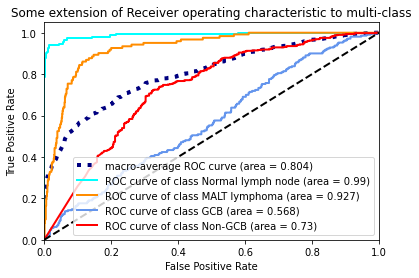

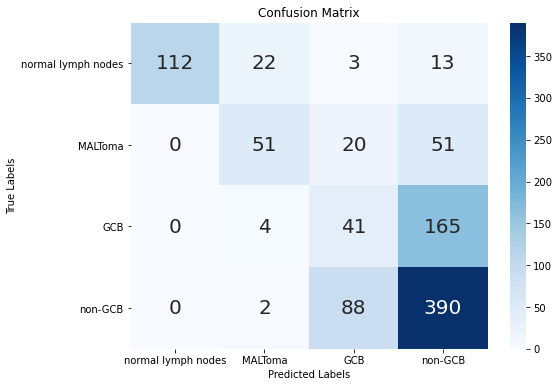

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2------------------------------------------------------------------------------
epoch:1 loss: 0.837 acc: 62.217
The current loss: 0.697734730623135
trigger times: 0
epoch:2 loss: 0.676 acc: 70.396
The current loss: 0.6253138594965145
trigger times: 0
epoch:3 loss: 0.586 acc: 74.688
The current loss: 0.49906774306931506
trigger times: 0
epoch:4 loss: 0.485 acc: 79.802
The current loss: 0.500830459228087
trigger times: 1
epoch:5 loss: 0.442 acc: 81.464
The current loss: 0.5040002863998809
trigger times: 2
epoch:6 loss: 0.383 acc: 84.852
The current loss: 0.30696976991850483
trigger times: 0
epoch:7 loss: 0.337 acc: 86.689
The current loss: 0.2919805877258795
trigger times: 0
epoch:8 loss: 0.306 acc: 87.907
The current loss: 0.2073018886837368
trigger times: 0
epoch:9 loss: 0.282 acc: 88.821
The current loss: 0.35376160776119564
trigger times: 1
epoch:10 loss: 0.254 acc: 90.326
The current loss: 0.18268534130766056
trigger times: 0
epoch:11 loss: 0.231 acc: 91.009
The current loss: 0

epoch:93 loss: 0.005 acc: 99.852
The current loss: 0.000835166478463413
trigger times: 0
epoch:94 loss: 0.001 acc: 99.954
The current loss: 0.00014340370770048424
trigger times: 0
epoch:95 loss: 0.000 acc: 100.000
The current loss: 0.00016581689563994803
trigger times: 1
epoch:96 loss: 0.019 acc: 99.465
The current loss: 0.0011203929979405804
trigger times: 2
epoch:97 loss: 0.001 acc: 99.982
The current loss: 0.00022124056627869222
trigger times: 0
epoch:98 loss: 0.001 acc: 99.972
The current loss: 0.01441509073355744
trigger times: 1
epoch:99 loss: 0.016 acc: 99.566
The current loss: 0.0016788343037497204
trigger times: 0
epoch:100 loss: 0.001 acc: 100.000
The current loss: 0.0010510604867744245
trigger times: 0
[[104  21   1  24]
 [  0  55  38  29]
 [  0   1  41 168]
 [  1   0  81 398]]


test accuracy : 0.622
test precison : 0.651
test recall : 0.542
test f : 0.578
AUC : 0.803
AUC for class 0: 0.988
AUC for class 1: 0.940
AUC for class 2: 0.548
AUC for class 3: 0.734


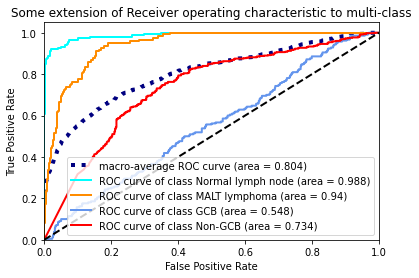

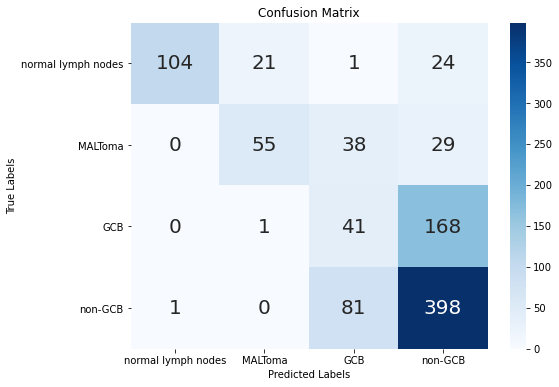

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3------------------------------------------------------------------------------
epoch:1 loss: 0.813 acc: 64.008
The current loss: 0.6533232620356819
trigger times: 0
epoch:2 loss: 0.675 acc: 70.211
The current loss: 0.6322600071757667
trigger times: 0
epoch:3 loss: 0.571 acc: 75.399
The current loss: 0.451665730785924
trigger times: 0
epoch:4 loss: 0.508 acc: 78.704
The current loss: 0.41875241319077683
trigger times: 0
epoch:5 loss: 0.415 acc: 83.144
The current loss: 0.37332855082914385
trigger times: 0
epoch:6 loss: 0.381 acc: 84.935
The current loss: 0.26509274591789966
trigger times: 0
epoch:7 loss: 0.338 acc: 86.532
The current loss: 0.259003100982184
trigger times: 0
epoch:8 loss: 0.298 acc: 88.480
The current loss: 0.2918835462293578
trigger times: 1
epoch:9 loss: 0.269 acc: 89.763
The current loss: 0.20424313094700688
trigger times: 0
epoch:10 loss: 0.228 acc: 91.480
The current loss: 0.4077411400787082
trigger times: 1
epoch:11 loss: 0.227 acc: 91.332
The current loss: 0

epoch:93 loss: 0.004 acc: 99.898
The current loss: 0.0005129112235430822
trigger times: 0
epoch:94 loss: 0.002 acc: 99.963
The current loss: 0.0001950183895633643
trigger times: 0
epoch:95 loss: 0.005 acc: 99.852
The current loss: 0.0008211373470107478
trigger times: 1
epoch:96 loss: 0.001 acc: 99.972
The current loss: 0.00013846007174076036
trigger times: 0
epoch:97 loss: 0.003 acc: 99.871
The current loss: 0.006043358853554374
trigger times: 1
epoch:98 loss: 0.008 acc: 99.677
The current loss: 0.026061925241139747
trigger times: 2
epoch:99 loss: 0.017 acc: 99.437
The current loss: 0.0004400503677501973
trigger times: 0
epoch:100 loss: 0.001 acc: 99.972
The current loss: 0.0016163191193460996
trigger times: 1
[[114  11   2  23]
 [  0  44  17  61]
 [  0   2  45 163]
 [  0   0 104 376]]


test accuracy : 0.602
test precison : 0.661
test recall : 0.530
test f : 0.569
AUC : 0.805
AUC for class 0: 0.994
AUC for class 1: 0.926
AUC for class 2: 0.590
AUC for class 3: 0.710


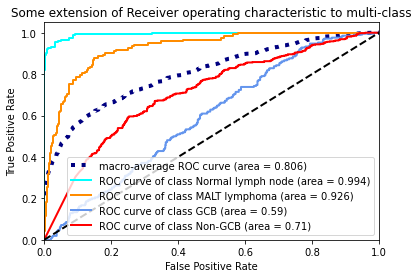

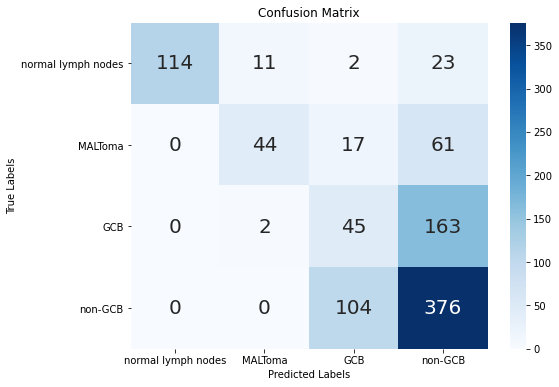

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4------------------------------------------------------------------------------
epoch:1 loss: 0.840 acc: 62.623
The current loss: 0.6990159406542371
trigger times: 0
epoch:2 loss: 0.684 acc: 70.036
The current loss: 0.5859254320601281
trigger times: 0
epoch:3 loss: 0.571 acc: 75.362
The current loss: 0.5001301783660924
trigger times: 0
epoch:4 loss: 0.496 acc: 79.775
The current loss: 0.3533317030153023
trigger times: 0
epoch:5 loss: 0.418 acc: 83.301
The current loss: 0.3438224342195142
trigger times: 0
epoch:6 loss: 0.394 acc: 84.067
The current loss: 0.33577394450656617
trigger times: 0
epoch:7 loss: 0.331 acc: 86.753
The current loss: 0.34156067608727714
trigger times: 1
epoch:8 loss: 0.292 acc: 88.424
The current loss: 0.2661604908825933
trigger times: 0
epoch:9 loss: 0.282 acc: 88.526
The current loss: 0.21759536326412346
trigger times: 0
epoch:10 loss: 0.242 acc: 90.455
The current loss: 0.1762596935292111
trigger times: 0
epoch:11 loss: 0.216 acc: 91.489
The current loss: 

epoch:93 loss: 0.008 acc: 99.806
The current loss: 0.004557448688626786
trigger times: 1
epoch:94 loss: 0.002 acc: 99.945
The current loss: 0.00012779191206316198
trigger times: 0
epoch:95 loss: 0.014 acc: 99.492
The current loss: 0.005257806060001189
trigger times: 1
epoch:96 loss: 0.004 acc: 99.880
The current loss: 0.0003482173161326131
trigger times: 0
epoch:97 loss: 0.000 acc: 100.000
The current loss: 0.00010138319825561493
trigger times: 0
epoch:98 loss: 0.002 acc: 99.963
The current loss: 0.0003391977629811097
trigger times: 1
epoch:99 loss: 0.018 acc: 99.418
The current loss: 0.0008697883506184399
trigger times: 2
epoch:100 loss: 0.002 acc: 99.917
The current loss: 0.033833296863868344
trigger times: 3
[[101   2   1  46]
 [  0  24  20  78]
 [  1   0  27 182]
 [  0   0 119 361]]


test accuracy : 0.533
test precison : 0.654
test recall : 0.438
test f : 0.475
AUC : 0.762
AUC for class 0: 0.988
AUC for class 1: 0.917
AUC for class 2: 0.506
AUC for class 3: 0.637


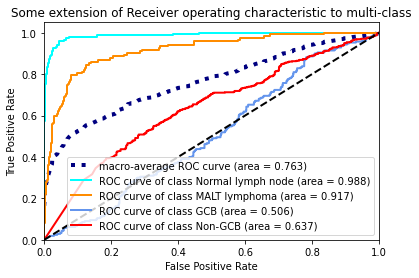

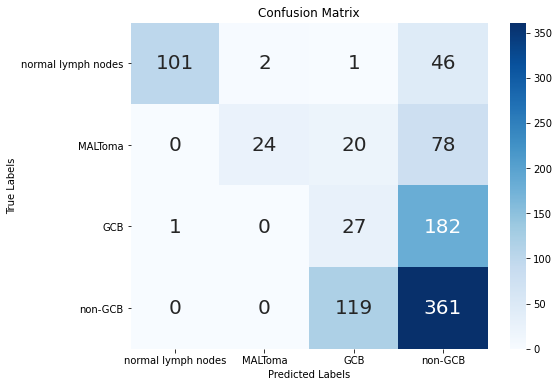

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 5------------------------------------------------------------------------------
epoch:1 loss: 0.823 acc: 63.390
The current loss: 0.6905015426485972
trigger times: 0
epoch:2 loss: 0.674 acc: 70.488
The current loss: 0.6430454514234754
trigger times: 0
epoch:3 loss: 0.551 acc: 76.609
The current loss: 0.6271697358198175
trigger times: 0
epoch:4 loss: 0.496 acc: 79.553
The current loss: 0.3859792031845436
trigger times: 0
epoch:5 loss: 0.424 acc: 82.572
The current loss: 0.31376653976347313
trigger times: 0
epoch:6 loss: 0.393 acc: 84.150
The current loss: 0.30747288340063655
trigger times: 0
epoch:7 loss: 0.336 acc: 86.652
The current loss: 0.371973081089848
trigger times: 1
epoch:8 loss: 0.299 acc: 88.433
The current loss: 0.20176926225544112
trigger times: 0
epoch:9 loss: 0.267 acc: 89.587
The current loss: 0.20754083391389072
trigger times: 1
epoch:10 loss: 0.245 acc: 90.603
The current loss: 0.18259872071013725
trigger times: 0
epoch:11 loss: 0.208 acc: 91.692
The current loss:

epoch:93 loss: 0.004 acc: 99.908
The current loss: 0.00044937970529807707
trigger times: 0
epoch:94 loss: 0.003 acc: 99.898
The current loss: 0.005588488370676332
trigger times: 1
epoch:95 loss: 0.001 acc: 99.991
The current loss: 0.0003927311491789435
trigger times: 0
epoch:96 loss: 0.006 acc: 99.788
The current loss: 0.004781040202067383
trigger times: 1
epoch:97 loss: 0.006 acc: 99.834
The current loss: 0.0023386374538178394
trigger times: 0
epoch:98 loss: 0.005 acc: 99.898
The current loss: 0.0001357673206022637
trigger times: 0
epoch:99 loss: 0.010 acc: 99.862
The current loss: 0.0002267110495994765
trigger times: 1
epoch:100 loss: 0.001 acc: 99.963
The current loss: 0.001253567354716949
trigger times: 2
[[ 95  32   2  21]
 [  0  48  10  64]
 [  0   2  32 176]
 [  1   4  74 401]]


test accuracy : 0.599
test precison : 0.606
test recall : 0.504
test f : 0.533
AUC : 0.781
AUC for class 0: 0.954
AUC for class 1: 0.912
AUC for class 2: 0.533
AUC for class 3: 0.727


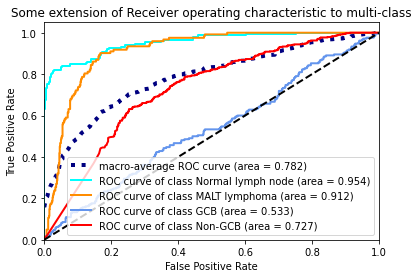

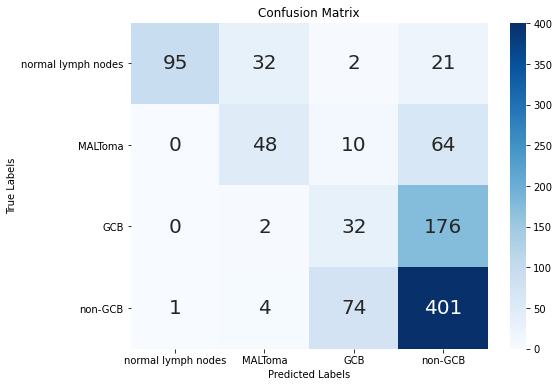

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 6------------------------------------------------------------------------------
epoch:1 loss: 0.846 acc: 62.374
The current loss: 0.6870355519471597
trigger times: 0
epoch:2 loss: 0.681 acc: 69.621
The current loss: 0.5612987906385078
trigger times: 0
epoch:3 loss: 0.568 acc: 75.399
The current loss: 0.538760203912107
trigger times: 0
epoch:4 loss: 0.501 acc: 79.082
The current loss: 0.4328921956517033
trigger times: 0
epoch:5 loss: 0.438 acc: 81.879
The current loss: 0.43445799427990606
trigger times: 1
epoch:6 loss: 0.403 acc: 83.892
The current loss: 0.3358971373844722
trigger times: 0
epoch:7 loss: 0.343 acc: 86.707
The current loss: 0.28906468046666156
trigger times: 0
epoch:8 loss: 0.295 acc: 88.286
The current loss: 0.38729503544867877
trigger times: 1
epoch:9 loss: 0.279 acc: 88.840
The current loss: 0.2208183323637595
trigger times: 0
epoch:10 loss: 0.255 acc: 90.197
The current loss: 0.24127682659566912
trigger times: 1
epoch:11 loss: 0.243 acc: 90.667
The current loss: 

The current loss: 0.0006986878001213041
trigger times: 1
epoch:93 loss: 0.003 acc: 99.935
The current loss: 0.0006835299745527391
trigger times: 0
epoch:94 loss: 0.003 acc: 99.926
The current loss: 0.0009087268414746247
trigger times: 1
epoch:95 loss: 0.014 acc: 99.538
The current loss: 0.004043617279387276
trigger times: 2
epoch:96 loss: 0.007 acc: 99.788
The current loss: 0.0003089624943986662
trigger times: 0


KeyboardInterrupt: 

In [9]:
%%time

def main():
    
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
    
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = models.vgg16(pretrained=True)
        num_ftrs = model.classifier[6].in_features

        # VGG16の最終層を4クラスの出力に変更
        model.classifier[6] = nn.Linear(num_ftrs, 4)

        # すべての層を訓練可能に設定
        for param in model.parameters():
            param.requires_grad = True

        model = model.to(device)

        batch_size = 32
        criterion = nn.CrossEntropyLoss()
        # Pass all model parameters to the optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) # Optimize the entire model for fine-tuning
        
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        cv_valid_dataset   = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
        
        print('Fold {}------------------------------------------------------------------------------'.format(_fold+1))

        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        test(device, model, test_dataloader)


if __name__ == '__main__':
    main()